In [1]:
!pip install -U albumentations

     -------------------------------------- 123.5/123.5 kB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 38.1/38.1 MB 2.7 MB/s eta 0:00:00


In [2]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
import os
import glob
import tensorflow  as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image, ImageEnhance
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input

In [3]:

path = r'E:\datasets\dataset_web'
path_imgs = list(glob.glob(path+'/**/*.jpg'))
all_paths=[]
#for label in os.listdir(path):
#    for image in os.listdir(path):
#        all_paths.append(path+label+'/'+image)
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_imgs))
file_path = pd.Series(path_imgs, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()
#x_train_paths = all_paths[:5000]
#def augment_image(image):
#   image = Image.fromarray(np.uint8(image))
#   image = ImageEnhance.Brightness(image).enhance(random.uniform(0.6,1.4))
#    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.6,1.4))
#   image = np.array(image)/255.0
#    return image
#def open_images(paths):
#    images = []
#   for path in paths:
#       image = load_img(path, target_size=(128,128))
#       image = augment_image(image)
#       images.append(image)
#    return np.array(images)
#train_aug =open_images (file_path) 

,File_Path,Labels
0,E:\datasets\dataset_web\cloudy\7809712.jpg,cloudy
1,E:\datasets\dataset_web\fogsmog\4820.jpg,fogsmog
2,E:\datasets\dataset_web\sunrise\299U7PW1IPW4.jpg,sunrise
3,E:\datasets\dataset_web\snow\247739012.jpg,snow
4,E:\datasets\dataset_web\snow\1012.jpg,snow


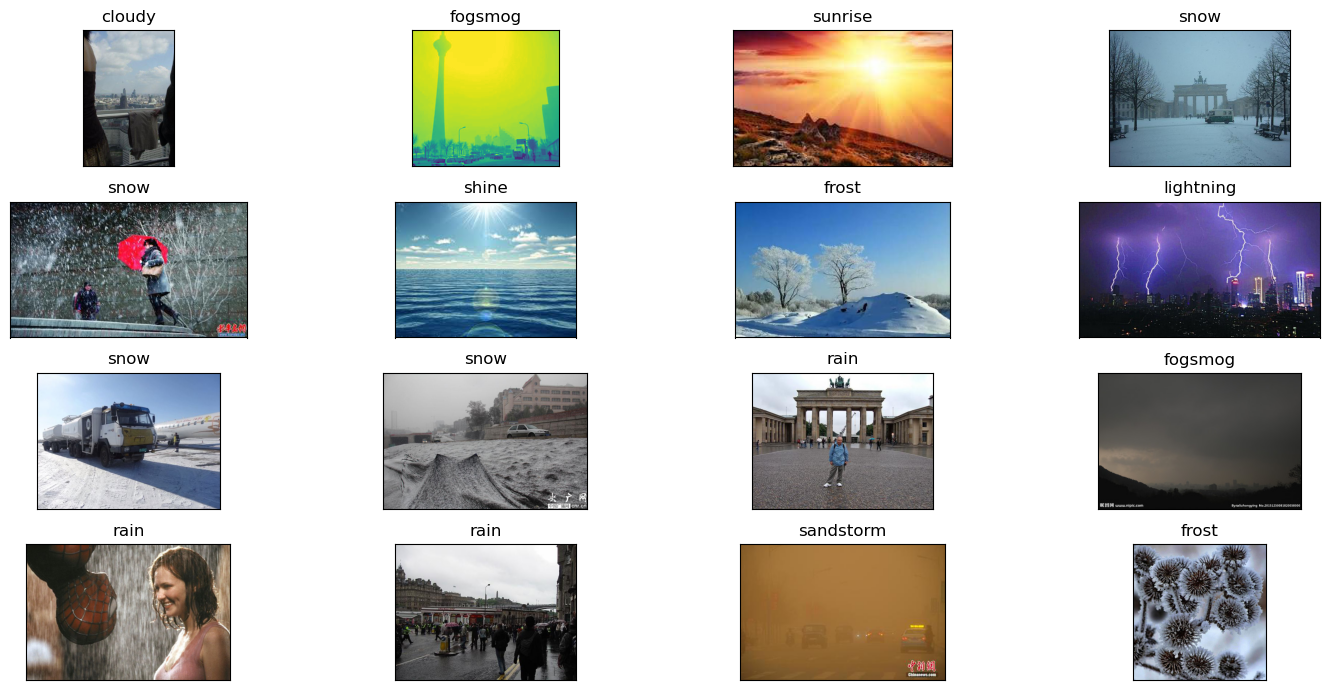

In [4]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()


In [6]:

train_df, test_df = train_test_split(data, test_size=0.2, random_state=2)


,File_Path,Labels
9085,E:\datasets\dataset_web\rain\68.jpg,rain
8113,E:\datasets\dataset_web\cloudy\26099417.jpg,cloudy
6054,E:\datasets\dataset_web\rain\rain19.jpg,rain
3408,E:\datasets\dataset_web\frost\5436.jpg,frost
10001,E:\datasets\dataset_web\dew\2852.jpg,dew
...,...,...
2514,E:\datasets\dataset_web\clear\25496577.jpg,clear
11798,E:\datasets\dataset_web\frost\5290.jpg,frost
6637,E:\datasets\dataset_web\rain\rain3.jpg,rain
2575,E:\datasets\dataset_web\frost\3821.jpg,frost


In [7]:

    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(299,299),
        class_mode='categorical',
        batch_size=32,
        rotation_range=30,
        shuffle=True,
        seed=0,
        subset='training'
        )
    val_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(299,299),
        class_mode='categorical',
        batch_size=32,
        rotation_range=30,
        shuffle=False,
        seed=0,
        subset='validation'
        )
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(299,299),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False)



Found 8436 validated image filenames belonging to 13 classes.
Found 2108 validated image filenames belonging to 13 classes.
Found 2636 validated image filenames belonging to 13 classes.


In [ ]:

base_model =tf.keras.applications.Xception(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=(299,299,3),
    classes=1000,
    classifier_activation="softmax",
)
base_model.trainable = False
adam_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
)
model = Sequential([
    base_model,
    layers.Dense(229, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(114 , activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(13, activation = 'softmax')
])

model.compile(optimizer=adam_optimizer,
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()
history = model.fit(train_gen, 
                    validation_data=val_gen, 
                    epochs=5,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                             patience=2)])
results = model.evaluate(val_gen)



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 1000)              22910480  
                                                                 
 dense_6 (Dense)             (None, 229)               229229    
                                                                 
 dropout_4 (Dropout)         (None, 229)               0         
                                                                 
 dense_7 (Dense)             (None, 114)               26220     
                                                                 
 dropout_5 (Dropout)         (None, 114)               0         
                                                                 
 dense_8 (Dense)             (None, 13)                1495      
                                                                 
Total params: 23,167,424
Trainable params: 256,944
Non

In [ ]:

pred = model.predict(test_gen )
pred = np.argmax(pred,axis=1)
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
cm=confusion_matrix(val_gen.Labels,pred)
clr = classification_report(val_gen.Labels, pred)
print(clr)

  
    

In [ ]:
test_results = {}
    
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.42881
Test Accuracy: 47.97%


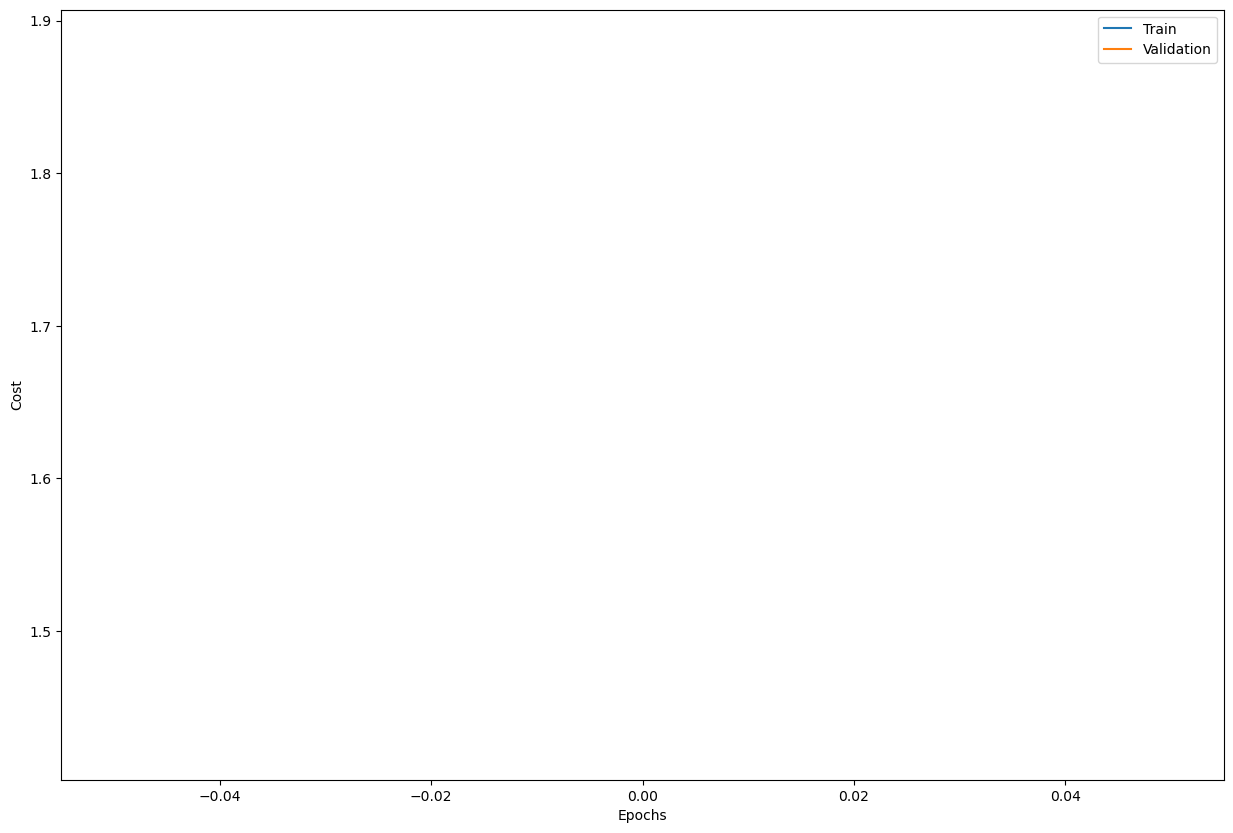

In [ ]:
print_loss(history)

In [ ]:
####model.save(r'C:\machine learning\first\first_ResNet50V2_model')